In this project, I want to answer some business questions based on AIRBNB data provided through Kaggle. I focused my interest to Seattle data specifically. I start with importing some libraries(the usual suspects)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import numpy as np
from collections import defaultdict

%matplotlib inline

In [2]:
#This part is for setting some standars of viewing in my notebook.
#pd.set_option('display.max_columns',500) 
#pd.set_option('display.max_rows', 25) # pandas to show rows
plt.rcParams['figure.figsize'] = [20, 10] # matplotlib plot size

In [3]:
calendar = pd.read_csv('./calendar.csv')
calendar.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
#listings = pd.read_csv('./listings.csv')
#listings.head(2)

In [5]:
#reviews = pd.read_csv('./reviews.csv')
#reviews.head()

First question I would like to find out is when do hosts tend to increase their prices. In order to do so, I am going to note down the dates where each listing is priced at its peak. I will then add up the number of times a date is listed as a maximum priced day for a single listing. The date with most "maximum priced" count will be the maximum priced date of the year. 

In order to do the calculations, I will be using the calendar dataset. Let's start by looking at the data to determine the necessary cleaning it requires.

In [6]:
calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

I need to convert the price to an integer and would like to work on date as a date type. Following functions will ensure those data type conversions:

In [7]:
def price_type_converter(df):
    df['price']=df['price'].replace('[\$,]','',regex=True).astype(float)
    return df

In [8]:
def date_type_converter(df):
    df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d', errors='ignore')
    return df

In [9]:
calendar = price_type_converter(calendar)

In [10]:
calendar = date_type_converter(calendar)

Let's check if conversions are properly applied:

In [11]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null datetime64[ns]
available     1393570 non-null object
price         934542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 42.5+ MB


## 1- When does each listing have the highest price?

It is time to extract the maximum priced days of each listing. I will create a Series called dates where I will append maximum priced nights from each listing.

In [12]:
dates=pd.Series()
for listing in calendar['listing_id'].unique():
    maximum_price = calendar[calendar['listing_id'] == listing]['price'].max()
    temp_df=calendar[calendar['listing_id']==listing]
    dates_temp=temp_df.loc[temp_df['price']== maximum_price]['date']
    dates = dates.append(dates_temp)

Next step is counting the appearance of each date in the series so that we will see when hosts hike up their prices the most. 

In [13]:
dates_counts=dates.value_counts()
dates_counts.head(15)

2016-12-31    2102
2016-12-30    2094
2016-12-24    2078
2016-12-23    2074
2016-08-27    2058
2016-08-26    2054
2016-09-03    2051
2016-12-17    2050
2016-09-02    2048
2016-12-16    2047
2016-06-25    2034
2016-12-10    2033
2016-12-09    2032
2016-08-20    2024
2016-06-24    2024
dtype: int64

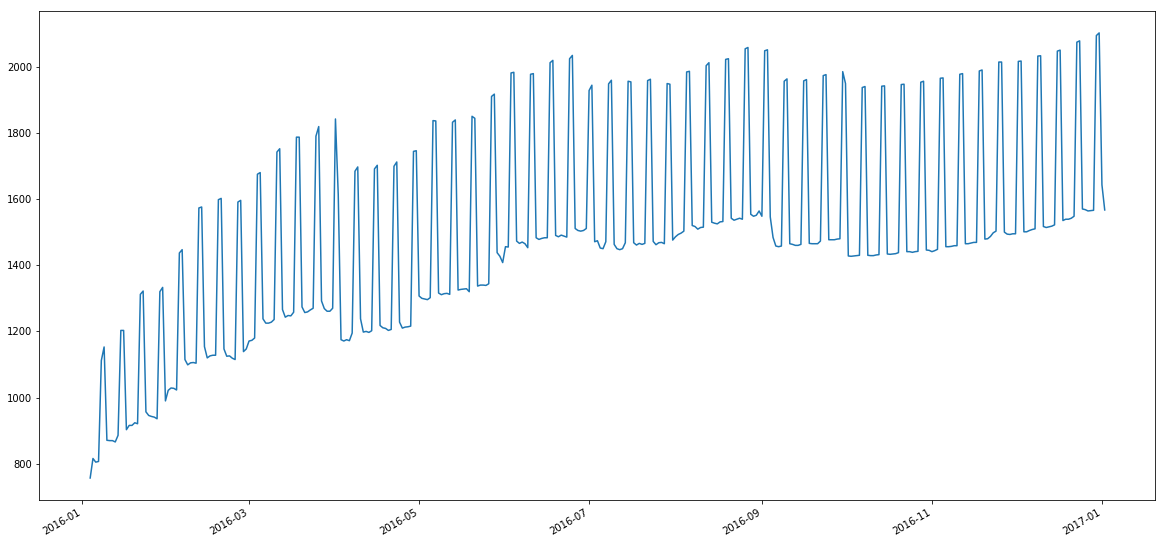

In [14]:
dates_counts.plot()

##### Looking at the plot and the values above, we can derive couple conclusions.

1- Most number of listings had their highest prices at the 30th and 31sh of December.

2- This is followed by the weekend before Christmas. Surprisingly the sunday before the Christmas was not hiked although it is holiday the day after.

3- The pattern of price drops from Sunday through Thursday can be easily observed as expected.

4- Hosts tend to hike up their prices during the holiday season. There is a clear pattern for more and more number of places coming up with their maximum price as we reach the end of the year. 

5- First three months of the year shows the dates with minimum number of maximum priced dates. 

###### It is important to note that
This analysis may be biased if some locations are only being listed on the dates with high prices. In order to understand the data better, I would like to ask 2 more questions.

## 2- When does Seattle has the most expensive night to stay?

I would like to plot the average cost of stay in Seattle throughout the year.

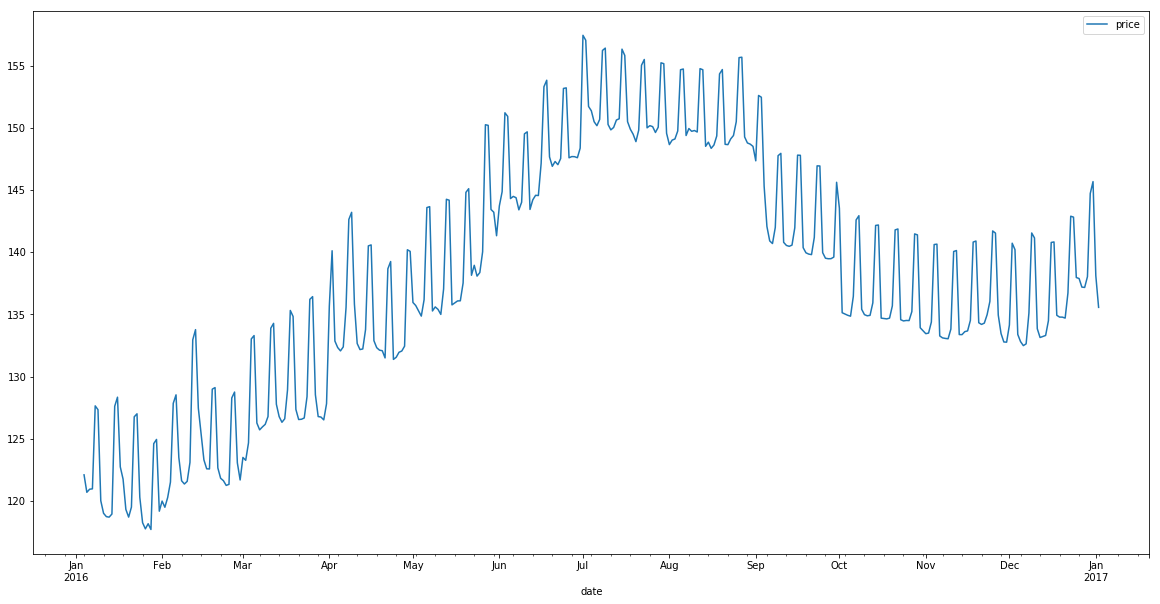

In [15]:
averages = pd.DataFrame( columns=['date','price'])
for date in calendar['date'].unique():
    average_price = calendar[calendar['date'] == date]['price'].mean()
    averages = averages.append({'date':date,'price':average_price}, ignore_index=True)
averages.plot(x='date',y='price')

As can be seen from the plot, accomodation prices are highest between mid July to September.

This can be due:

1- the lack of listings at the time period and only expensive locations being listed

2- demand and a price hike for all listings.

I will start with investigating the number of listings first.

## 3- When does Seattle have the most number of listings throughout the year? 

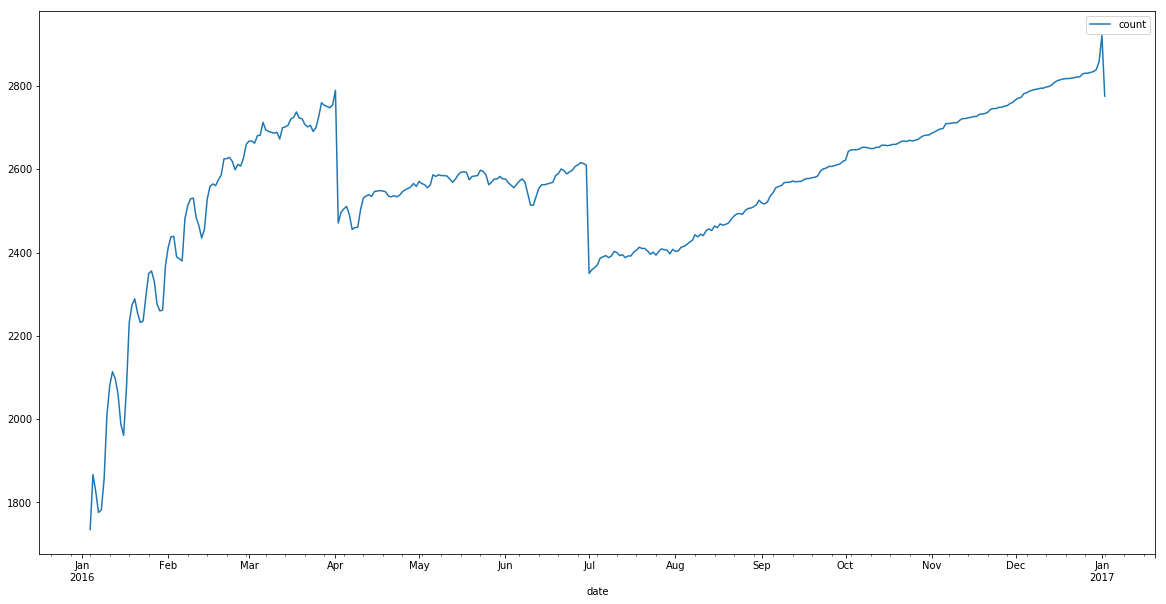

In [16]:
deneme = pd.DataFrame( columns=['date','count'])
available_calendar = calendar[calendar['available'] == 't']
for date in calendar['date'].unique():
    available=available_calendar[available_calendar['date'] == date].shape[0]
    deneme = deneme.append({'date':date,'count':available}, ignore_index=True)
deneme.plot(x='date',y='count')

We can see that there is a drop in the number of listings after April and after July. This can be contributing the increase in prices during the summer. However cannot be concluded as the only reason. Looking at the plot, one can see that there are less listings between January to March yet we know that average prices are also the lowest for that timeframe. 

So it is a good idea to have a look at one final data before wrapping our study. Let's only look at listings with at least one summer and at least one non summer date to see if hosts really hike their prices during summer.

## 4- Do hosts increase prices during Summer?

Now having seen that number of listings increased at the end of the year, it is time to repeat the first study with a tweak. 

Let's focus only on listings that were available throughout the whole year. Then look at where those listings had their maximum pricing at.

Following code counts the number of availabilities during the summer for each listing. If There is no availability for the total of 121 days of summer, that listing had no availability during summer.

In [17]:
all_year=[]
for listing in calendar['listing_id'].unique():
    if len(calendar[calendar['listing_id'] == listing][calendar[calendar['listing_id'] == listing]
                                                          ['available']== 't']) == 365:
        all_year.append(listing)

In [18]:
calendar_reduced = calendar[calendar['listing_id'].isin(all_year)]

We have obtained a new dataframe with reduced listings. Let's run the first analysis on this dataframe to see the results.

In [19]:
dates=pd.Series()
for listing in calendar_reduced['listing_id'].unique():
    maximum_price = calendar_reduced[calendar_reduced['listing_id'] == listing]['price'].max()
    temp_df=calendar_reduced[calendar_reduced['listing_id']==listing]
    dates_temp=temp_df.loc[temp_df['price']== maximum_price]['date']
    dates = dates.append(dates_temp)
dates_counts=dates.value_counts()

In [20]:
dates_counts.head(15)

2016-07-01    627
2016-07-02    627
2016-07-15    622
2016-07-16    622
2016-07-29    622
2016-07-30    621
2016-07-23    621
2016-08-06    621
2016-08-05    621
2016-07-22    620
2016-07-09    620
2016-07-08    620
2016-08-13    619
2016-06-11    619
2016-08-12    619
dtype: int64

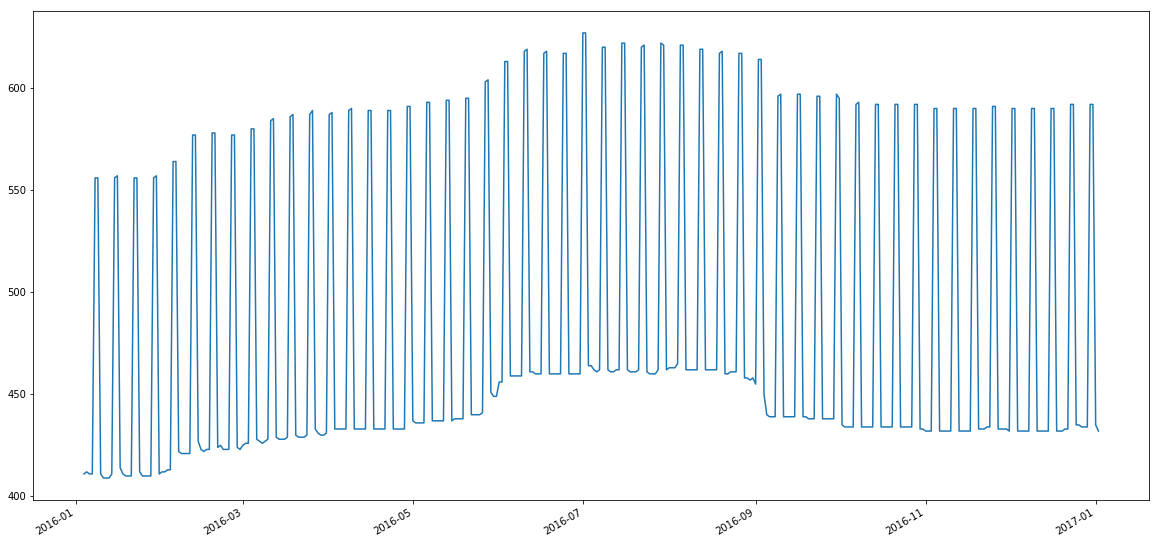

In [21]:
dates_counts.plot()

Also let's have a look at the average price for these locations.

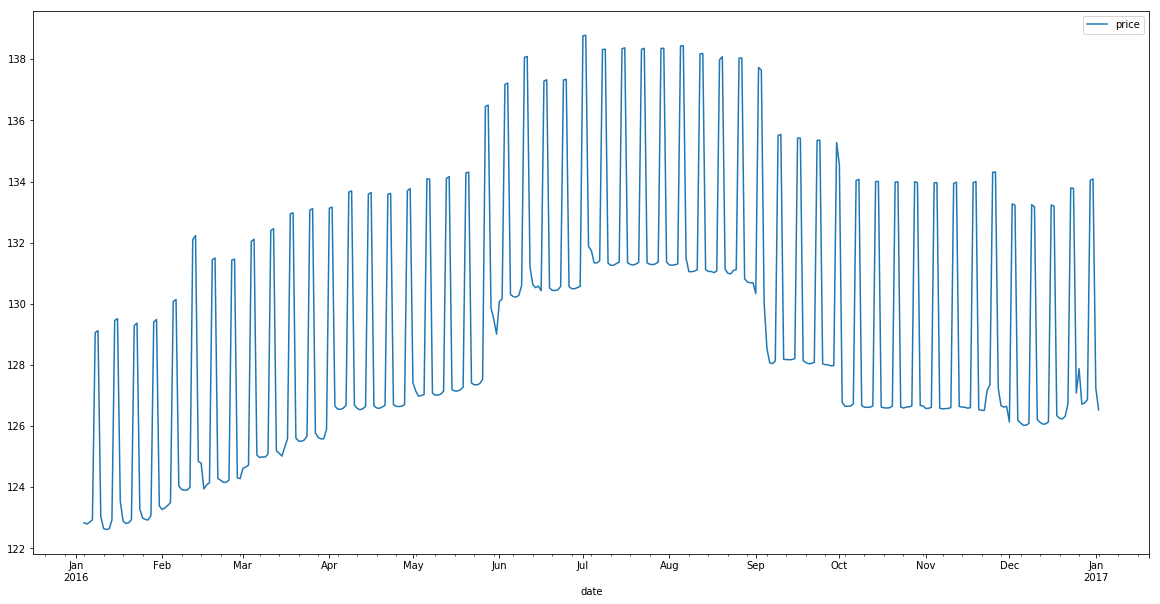

In [22]:
averages = pd.DataFrame(columns=['date','price'])
for date in calendar_reduced['date'].unique():
    average_price = calendar_reduced[calendar_reduced['date'] == date]['price'].mean()
    averages = averages.append({'date':date,'price':average_price}, ignore_index=True)
averages.plot(x='date',y='price')

Looking at the plot above we can easily conclude certain patterns for the year since these locations are listed throughout the whole year.

1- We can see the gradual increase of prices from beinning of the year to Summer. More and more hosts start listing their location at their maximum price.

2- We know the price increase is not happening because just couple places increase their prices in huge numbers but many listings increase their prices.

## Conclusion

This study asked a couple questions

1 - When does the Seattle AirBNB listings have their highest prices?

 We first looked at all the data and tried to see if maximum prices are mostly marked during a certain time. However, this initial study had flaws such as some locations were only listed at those special dates and showing up as marked up price

2 - When does the Seattle AirBNB has the most amount of availability?

We have seen that just before the summer and through the holiday season, Seattle has more offerings

3 -  What is the average cost of stay at Seattle throughout the year?

We have seen that Seattle has a pike in accomodation during the summer and at the end of the year

Then we wanted to understand if this increase price is happening due to the new listings, so we reduced our db to listings with throughout the year offerings.

4- Does Seattle AirBnb hosts mark up their prices during summer?

We have clearly seen the answer is yes